In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from pyspark.sql import SparkSession, DataFrame

In [2]:
sp = (
    SparkSession.builder.appName("Model")
    .config("spark.sql.session.timeZone", "+11")
    #.config("spark.driver.memory", "10g")
    #.config("spark.executor.memory", "10g")
    #.config('spark.sql.parquet.cacheMetadata', 'True')
    .getOrCreate()
)
sp

22/10/16 23:28:02 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.21.176.78 instead (on interface eth0)
22/10/16 23:28:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/16 23:28:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/16 23:28:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
sns.set_style("whitegrid")
sns.set_palette("winter")

Read the model output data

In [4]:
dataset = sp.read.option("inferSchema", True).parquet("../models/random_forest_output_full/")
selected = dataset.select("merchant_abn", "order_datetime", "postcode", "prediction")
selected.show(2)

+------------+--------------+--------+----------+
|merchant_abn|order_datetime|postcode|prediction|
+------------+--------------+--------+----------+
| 87639550697|    2022-05-22|    6625|       1.0|
| 57900494384|    2022-05-22|    1597|       1.0|
+------------+--------------+--------+----------+
only showing top 2 rows



In [4]:
avg_merchant_pred = selected.groupBy("merchant_abn").avg("prediction").toPandas()
avg_merchant_pred.head()

,merchant_abn,avg(prediction)
0,83412691377,1.0
1,73256306726,1.0
2,38700038932,1.0
3,73841664453,1.0
4,35344855546,1.0


In [5]:
date_of_fraud = selected.filter(col("prediction") > 1).toPandas()
date_of_fraud.head()

,merchant_abn,order_datetime,postcode,prediction
0,96152467973,2022-07-19,3186,9.0
1,89726005175,2022-07-25,3123,9.0
2,96152467973,2022-08-01,3123,9.0
3,57900494384,2022-03-19,3186,9.0
4,71787414647,2022-03-19,3186,9.0


In [6]:
date_of_fraud.count()

merchant_abn      838
order_datetime    838
postcode          838
prediction        838
dtype: int64

Comparing predicted and real distributions of fraud probability

In [8]:
consumer_fraud = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
consumer_fraud.head()

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425


In [9]:
consumer_fraud["fraud_probability"] = np.floor(consumer_fraud["fraud_probability"] / 10)
consumer_fraud.head()

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,9.0
1,21419,2021-12-10,9.0
2,5606,2021-10-17,8.0
3,3101,2021-04-17,9.0
4,22239,2021-10-19,9.0


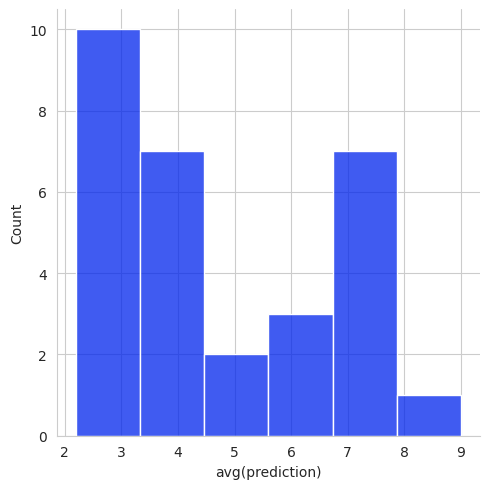

In [12]:
sns.displot(avg_merchant_pred[avg_merchant_pred["avg(prediction)"] > 1.5]["avg(prediction)"])

In [13]:
postcodes = selected.groupBy("postcode").avg("prediction").toPandas()
postcodes.head(2)

,postcode,avg(prediction)
0,5556,1.0
1,4823,1.0


In [5]:
import folium
import geopandas as gpd

In [6]:
sf = gpd.read_file("../data/tables/geo_data/POA_2021_AUST_GDA2020.shp")
sf.head(2)

,POA_CODE21,POA_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
0,0800,0800,AUS,Australia,3.1731,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.081893,0.000264,"POLYGON ((130.83681 -12.45376, 130.83684 -12.4..."
1,0810,0810,AUS,Australia,24.4283,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.241859,0.002031,"POLYGON ((130.89986 -12.36567, 130.89875 -12.3..."


In [7]:
sf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POA_CODE21  2644 non-null   object  
 1   POA_NAME21  2644 non-null   object  
 2   AUS_CODE21  2644 non-null   object  
 3   AUS_NAME21  2644 non-null   object  
 4   AREASQKM21  2644 non-null   float64 
 5   LOCI_URI21  2644 non-null   object  
 6   SHAPE_Leng  2644 non-null   float64 
 7   SHAPE_Area  2644 non-null   float64 
 8   geometry    2641 non-null   geometry
dtypes: float64(3), geometry(1), object(5)
memory usage: 186.0+ KB


In [22]:
selected.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- postcode: long (nullable = true)
 |-- prediction: double (nullable = true)



In [8]:
postcode = selected.groupBy("postcode").avg("prediction")
postcode_pd = postcode.toPandas()
postcode_pd.columns = ["POA_CODE21", "Fraud Prediction"]

In [10]:
sf = sf.dropna()
sf["POA_CODE21"] = sf["POA_CODE21"].astype("int64")
sf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2641 entries, 0 to 2640
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POA_CODE21  2641 non-null   int64   
 1   POA_NAME21  2641 non-null   object  
 2   AUS_CODE21  2641 non-null   object  
 3   AUS_NAME21  2641 non-null   object  
 4   AREASQKM21  2641 non-null   float64 
 5   LOCI_URI21  2641 non-null   object  
 6   SHAPE_Leng  2641 non-null   float64 
 7   SHAPE_Area  2641 non-null   float64 
 8   geometry    2641 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(4)
memory usage: 206.3+ KB


In [ ]:
geoJSON = sf[['POA_CODE21', 'geometry']].drop_duplicates("POA_CODE21").to_json()

m = folium.Map(location=[-37.8124, 144.9623], tiles="Stamen Terrain", zoom_start=11)

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=postcode_pd, # data source
    columns=['POA_CODE21','Fraud Prediction'], # the columns required
    key_on='properties.POA_CODE21', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average Predicted Fraud Prediction by Postcode'
)
c.add_to(m)

m